In [1]:
##Created by Prerit Jain

In [1]:
import importlib
import prompts.router_prompt
importlib.reload(prompts.router_prompt)
import prompts.retrieval_grade_prompt
importlib.reload(prompts.retrieval_grade_prompt)
import prompts.question_rewriter
importlib.reload(prompts.question_rewriter)
import prompts.qna_template
importlib.reload(prompts.qna_template)
import prompts.intro_gen_prompt
importlib.reload(prompts.intro_gen_prompt)

<module 'prompts.intro_gen_prompt' from 'c:\\Users\\prerit.d.jain\\OneDrive - Accenture\\JTI\\python_codes\\rfx-chatbot-demo\\prompts\\intro_gen_prompt.py'>

In [2]:
import os
from data_preprocessing import data_preprocessing
from pathlib import Path
from vector_store import vector_store
from uuid import uuid4
from typing import Literal, List
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from llm_calling import llm_calling
from prompts.router_prompt import router_prompt
from prompts.retrieval_grade_prompt import retrieval_grade_prompt
from prompts.question_rewriter import question_rewriter
from prompts.qna_template import sections_create
from prompts.intro_gen_prompt import intro_gen_prompt
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts.prompt import PromptTemplate
from typing_extensions import TypedDict
from langchain.schema import Document
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display
from pprint import pprint
from langchain_qdrant import QdrantVectorStore

c:\Users\prerit.d.jain\OneDrive - Accenture\JTI\python_codes\rfx-chatbot-demo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def file_names(directory):
    files=[]
    for file in os.listdir(directory):
        if file.endswith(".pdf"):
            files.append(os.path.join(directory, file))
    return files

In [6]:
def langchain_doc_creation(file_path):
    doc=[]
    for f in file_path:
        dp = data_preprocessing(file_path=f)
        doc += dp.load_data()
    return doc

### Denser Vector Embeddings

In [7]:
def load_existing_vdb_collection(embeddings,collection_name,path):
    vs_dense = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name=collection_name,
    path=path
    )
    return vs_dense

def create_new_vdb(directory,collection_name,embeddings,path,type_of_retrieval):
    directory = directory
    file_path = file_names(directory)
    doc_input = langchain_doc_creation(file_path)
    embeddings = embeddings
    if type_of_retrieval == "dense":
        vs_dense = vector_store(collection_name=collection_name,embeddings=embeddings,path=path).vector_qdrant_dense()
    elif type_of_retrieval == "sparse":
        vs_dense = vector_store(collection_name=collection_name,embeddings=embeddings,path=path).vector_qdrant_sparse()
    else:
        vs_dense = vector_store(collection_name=collection_name,embeddings=embeddings,path=path).vector_qdrant_hybrid
    uuids = [str(uuid4()) for _ in range(len(doc_input))]
    vs_dense.add_documents(documents=doc_input, ids=uuids)

    return vs_dense

In [8]:
embeddings = llm_calling(embedding_model="llama3.2:latest").call_embed_model()

In [9]:
type_of_retrieval = "dense" #@param ["dense", "sparse", "hybrid"]

In [10]:
collection_name = f"""jti_rfp_{type_of_retrieval}"""
path = f"""./tmp/langchain_qdrant_{type_of_retrieval}"""
my_file = Path(path+f"""/collection/{collection_name}/storage.sqlite""")
directory = "./Input_Files"

if my_file.is_file():
    print("DB Exists")
    vs_dense = load_existing_vdb_collection(embeddings=embeddings,collection_name=collection_name,path=path)
else:
    print("DB Doesnt Exists")
    vs_dense = create_new_vdb(directory=directory,collection_name=collection_name,embeddings=embeddings,path=path,type_of_retrieval=type_of_retrieval)

DB Exists


In [11]:
collection_name = f"""jti_rfp_{type_of_retrieval}_user"""
path = f"""./tmp/langchain_qdrant_user_{type_of_retrieval}"""
my_file = Path(path+f"""/collection/{collection_name}/storage.sqlite""")
directory = "./User_File"

if my_file.is_file():
    print("DB Exists")
    vs_dense_user = load_existing_vdb_collection(embeddings=embeddings,collection_name=collection_name,path=path)
else:
    print("DB doesnt Exists")
    vs_dense_user = create_new_vdb(directory=directory,collection_name=collection_name,embeddings=embeddings,path=path,type_of_retrieval=type_of_retrieval)

DB Exists


In [12]:
retriever_input = vs_dense.as_retriever(search_type="similarity", search_kwargs={"k": 3})
retriever_user = vs_dense_user.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [13]:
llm = llm_calling(model_name="qwen2.5:7b").call_llm()

### Router

In [14]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["retrieve_universal", "retrieve_user"] = Field(
        ...,
        description="There are two vectorstores. Given a user question choose to route it to the vectorstore for Input Files or a vectorstore for User Files.",
    )

structured_llm_router = llm.with_structured_output(RouteQuery)
system = router_prompt
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Can you tell me a little about the Evaluation criteria for the RFP?"}
    )
)
print(question_router.invoke({"question": "From the document uploaded, can you tell me about the evaluation criterial for the RFP?"}))

datasource='retrieve_universal'
datasource='retrieve_user'


### Retrieval Accuracy

In [15]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = retrieval_grade_prompt
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [16]:
question = "Create an Intoduction section for the RFP document, giving a bried overview on JTI (Japan Tobacco International)."
docs = retriever_input.invoke(question)
doc_txt=''
for d in docs:
    doc_txt+= d.page_content
    doc_txt+= "\n\n"

In [17]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [18]:
question = "Create an Intoduction section for the RFP document, giving a bried overview on JTI (Japan Tobacco International)."
docs = retriever_user.invoke(question)
doc_txt=''
for d in docs:
    doc_txt+= d.page_content
    doc_txt+= "\n\n"

In [19]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Question Rewriter

In [20]:
### Question Re-writer

# Prompt
system = question_rewriter
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'How can I create an introduction section for the RFP document that provides a brief overview of Japan Tobacco International (JTI)?'

### Section Creator

In [21]:
prompt=PromptTemplate(template=sections_create, input_variables=['question','context'])
question="How can I create an introduction section for the RFP document that provides a brief overview of Japan Tobacco International (JTI)?"
docs = retriever_input.invoke(question)

In [22]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()
docs = format_docs(docs)

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

To create an introduction section for the RFP document that provides a brief overview of Japan Tobacco International (JTI), you can use the following template based on the provided context:

---

**Introduction**

Japan Tobacco International (JTI) is a leading international tobacco and vaping company headquartered in Geneva, Switzerland. Our goal is to become the most successful and responsible tobacco company in the world. JTI operates globally with a commitment to sustainability, youth access prevention, and reducing health risks associated with smoking through the development of alternative products.

For more detailed information about JTI's global operations, please refer to Appendix 1 of this document. To learn more about our local market presence and initiatives, visit our website at [local website].

---

This introduction section provides a concise overview of JTI, highlighting its mission, global operations, and local market focus, which aligns with the context provided.


In [24]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [25]:
def retrieve_universal(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever_input.invoke(question)
    return {"documents": documents, "question": question}

def retrieve_user(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever_user.invoke(question)
    return {"documents": documents, "question": question}

In [26]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [27]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [25]:
def transform_query_w_retriever(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    #documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}

In [26]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "retrieve_universal":
        print("---ROUTE QUESTION TO UNIVERSAL VECTORSTORE---")
        return "retrieve_universal"
    elif source.datasource == "retrieve_user":
        print("---ROUTE QUESTION TO USER VECTORSTORE---")
        return "retrieve_user"

In [27]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [35]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve_universal", retrieve_universal)  # web search
workflow.add_node("retrieve_user", retrieve_user)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("transform_query_w_retriever", transform_query_w_retriever)  # transform_query

# Build graph
workflow.add_edge(START, "transform_query")  # route question
workflow.add_conditional_edges(
    "transform_query",
    route_question,
    {
        "retrieve_universal":"retrieve_universal",
        "retrieve_user":"retrieve_user",
    },
)
workflow.add_edge("retrieve_universal", "grade_documents")
workflow.add_edge("retrieve_user", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
# workflow.add_conditional_edges(
#     "transform_query_w_retriever",
#     route_question,
#     {
#         "retrieve_universal":"retrieve_universal",
#         "retrieve_user":"retrieve_user",
#     },
# )
#workflow.add_edge("transform_query", "retrieve")
# workflow.add_conditional_edges(
#     "generate",
#     grade_generation_v_documents_and_question,
#     {
#         "not supported": "generate",
#         "useful": END,
#         "not useful": "transform_query",
#     },
# )

# Compile
app = workflow.compile()

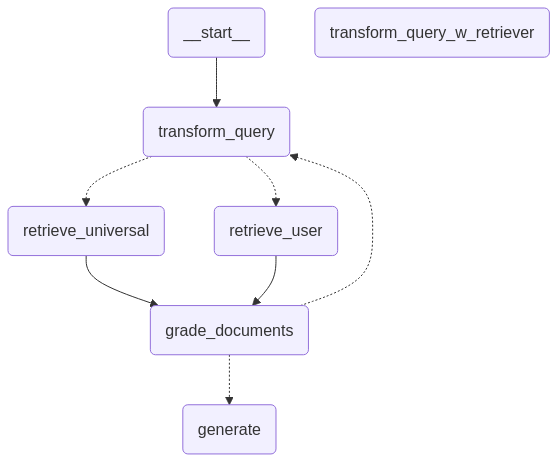

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [33]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
# Run
inputs = {
    "question": "Create an Intoduction section for the RFP document, giving a bried overview on JTI (Japan Tobacco International)."
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---TRANSFORM QUERY---
---ROUTE QUESTION---
---ROUTE QUESTION TO UNIVERSAL VECTORSTORE---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve_universal':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('To create an introduction section for the RFP document that provides a brief '
 'overview of Japan Tobacco International (JTI), you can follow this '
 'structure:\n'
 '\n'
 '---\n'
 '\n'
 '**Introduction**\n'
 '\n'
 'Japan Tobacco International (JTI) is a leading international tobacco and '
 'vaping company headquartered in Geneva, Switzerland. Our mission is to '
 'become the most successful and responsible tobacco company in the world. JTI '
 'operates globally, respecting local legislation, norms, and cultures '
 'wherever we marke